# View at nbviewer

[https://nbviewer.org/github/edwstanzah/HR-Analytics/blob/main/modelling.ipynb]

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# estimators and utilities
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier


# preprocess and pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline, make_pipeline

# model scoring and validation
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay
from sklearn.metrics import PrecisionRecallDisplay

In [22]:
# import custom functions
import CustomFunctions

In [4]:
df = pd.read_csv('data/feature_engineering.csv')

In [5]:
# check for class imbalance
df.is_promoted.value_counts()

0    50140
1     4668
Name: is_promoted, dtype: int64

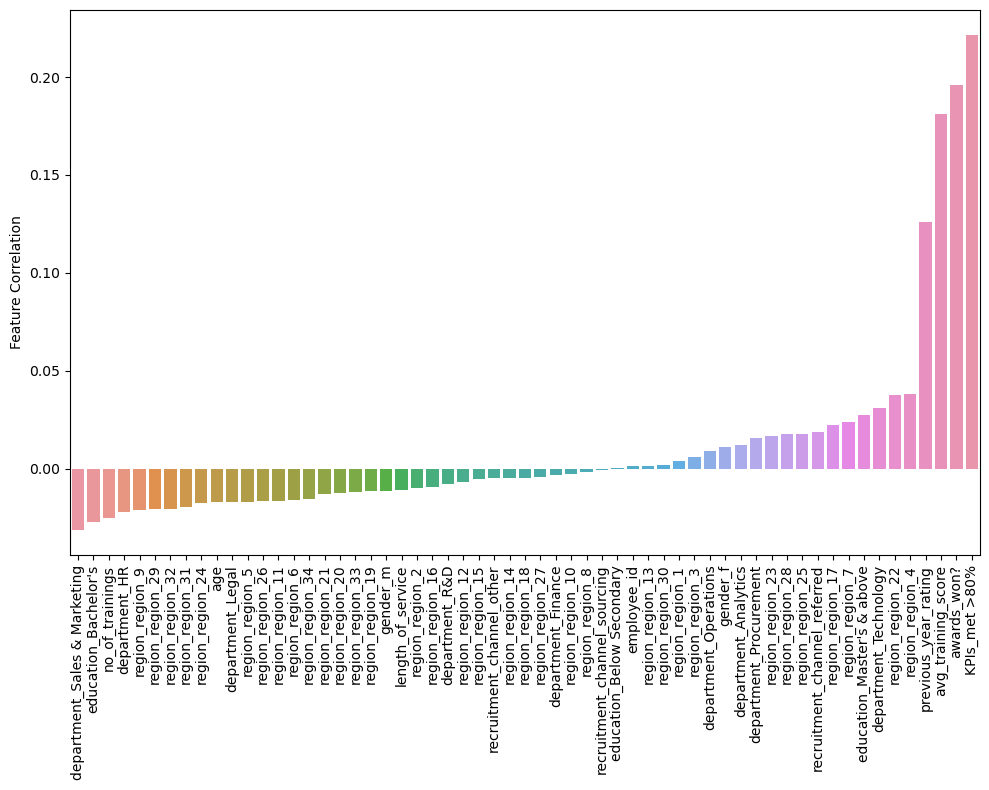

In [6]:
# plot the feature correlation with the target
feat_corr = df.corr()['is_promoted'].sort_values()[:-1]

plt.figure(figsize=(10,8), dpi=100)
sns.barplot(x=feat_corr.index, y=feat_corr.values)
plt.ylabel('Feature Correlation')
plt.xticks(rotation=90)
plt.tight_layout();

In [7]:
X = df.drop(['employee_id', 'is_promoted'], axis=1)
y = df['is_promoted']

# Train Test Split

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# Scaling

In [9]:
scaler = StandardScaler()
scaled_X_train = scaler.fit_transform(X_train)
scaled_X_test = scaler.transform(X_test)

# Models Selection

Here, we take a look at various models with default parameters to see how they compare with each other. We'll then look at the best algorithms and tune their hyperparameters to improve on the base results.

In [10]:
# set up pipelines
models = {
    'lr': make_pipeline(scaler, LogisticRegression()),
    'rfr': make_pipeline(RandomForestClassifier()),
    'svc': make_pipeline(scaler, SVC()),
    'knn': make_pipeline(scaler, KNeighborsClassifier()),
    'dtc': make_pipeline(DecisionTreeClassifier())
}

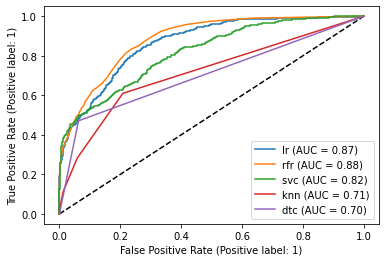

In [12]:
_, ax= plt.subplots()
plt.plot([0, 1], [0, 1], linestyle='--', c='black');
for name, estimator in models.items():
    y_pred = estimator.fit(X_train, y_train).predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    RocCurveDisplay.from_estimator(estimator, X_test, y_test, name="{}".format(name), ax=ax)

Logistic Regression and Random Forest are the two best according to the ROC curves. Although ROC curves are not a perfect metrics, especially for imbalanced datasets such as what we have here, it's a good baseline to decide which models to consider. In this notebook, we shall tune the hyperparameters for Logistic Regression and ensemble tree-based methods. 

# Logistic Regression



### Class Weight

The response is imbalanced. One of the ways to deal with it is to penalize misclassification with the class_weight parameter. We'll try to estimate the best class_weight for this dataset by plotting F1 scores against the weighting.

c:\Users\61411\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


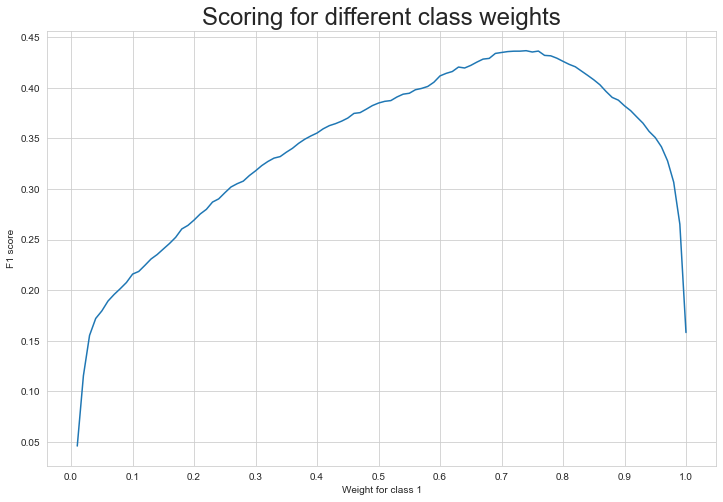

In [13]:
from sklearn.model_selection import StratifiedKFold
lr = LogisticRegression(solver='newton-cg')

#Setting the range for class weights
weights = np.linspace(0.0, 0.99, 100)

#Creating a dictionary grid for grid search
param_grid = {'class_weight': [{0:x, 1:1.0-x} for x in weights]}

#Fitting grid search to the train data with 5 folds
gridsearch = GridSearchCV(estimator= lr, 
                          param_grid= param_grid,
                          cv=StratifiedKFold(), 
                          n_jobs=-1, 
                          scoring='f1').fit(X_train, y_train)

#Ploting the score for different values of weight
sns.set_style('whitegrid')
plt.figure(figsize=(12,8))
weigh_data = pd.DataFrame({ 'score': gridsearch.cv_results_['mean_test_score'], 'weight': (1- weights)})
sns.lineplot(weigh_data['weight'], weigh_data['score'])
plt.xlabel('Weight for class 1')
plt.ylabel('F1 score')
plt.xticks([round(i/10,1) for i in range(0,11,1)])
plt.title('Scoring for different class weights', fontsize=24);

In [14]:
# find best performing weight
weigh_data.iloc[weigh_data['score'].idxmax()]

score     0.436663
weight    0.740000
Name: 26, dtype: float64

### Grid Search

In [15]:
lr_params = {
    'penalty': ['l2', None],
    'class_weight':['balanced', {0:.26, 1:.74}, {0:1, 1:10}],
    'solver': ['newton-cg', 'lbfgs', 'sag'],
    'C': [0.1, 1, 5, 10],
    'random_state': [42]
}

base_lr = LogisticRegression()

grid_lr = GridSearchCV(base_lr,
                       param_grid=lr_params,
                       cv=StratifiedKFold(),
                       n_jobs=-1,
                       scoring='f1').fit(scaled_X_train, y_train)

c:\Users\61411\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
180 fits failed out of a total of 360.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
180 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\61411\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\61411\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "c:\Users\61411\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 441, in _check_solver
    raise ValueError(
V

# Random Forest, AdaBoost, and Gradient Boosting

### Random Forest Grid Search

In [16]:
rfr = RandomForestClassifier()

rfr_params = {
    'n_estimators': [64, 100, 128, 200],
    'criterion': ['gini', 'entropy'],
    'max_features': ['auto', 'log2', None],
    'class_weight': ['balanced', 
                    'balanced_subsample', 
                    {0:1, 1:10}, 
                    {0:.26, 1:.74},
                    None],
    'min_samples_leaf': np.arange(2,5),
    'random_state': [42]
}

rfr_grid = GridSearchCV(rfr, 
                        param_grid=rfr_params, 
                        scoring='f1',
                        cv=StratifiedKFold(),
                        n_jobs=-1).fit(scaled_X_train, y_train)

### AdaBoost Grid Search

In [17]:
# grid search with AdaBoostClassifier
weighted_stump = DecisionTreeClassifier(max_depth=1, 
                                        class_weight={0:.26, 1:.74})
ada_params = {
    'base_estimator': [None, weighted_stump],
    'n_estimators': [5, 10, 20, 30, 50, 80, 100],
    'learning_rate':[0.1, 0.2, 0.5, 1.0],
    'random_state': [42]
    }

ada_grid = GridSearchCV(AdaBoostClassifier(),
                        param_grid=ada_params,
                        cv=StratifiedKFold(),
                        scoring='f1',
                        n_jobs=-1).fit(scaled_X_train, y_train)

### GradietBoosting Grid Search

In [18]:
gb_params = {
    'n_estimators':[100, 150, 200, 250],
    'max_depth':[3,4,5,6], 
    'random_state': [42]
    }

gb_grid = GridSearchCV(GradientBoostingClassifier(),
                       param_grid=gb_params, 
                       scoring='f1', 
                       cv=StratifiedKFold(), 
                       n_jobs=-1).fit(scaled_X_train, y_train)

# Models Evaluation

In the models below, we use scaled features because the best parameters for logistic regression include L2 penalty. Feature scaling helps achieve better results with regularization. Also, it does not affect the output of tree-based methods. Hence, the use of scaled X features for all models.

In [19]:
# set params to the values found by grid search
best_lr_params = grid_lr.best_params_
best_rfr_params = rfr_grid.best_params_
best_ada_params = ada_grid.best_params_
best_gb_params = gb_grid.best_params_

# create a dict containing all models and fit them with scaled features
best_models = {
    'Logistic Regression': LogisticRegression(**best_lr_params).fit(scaled_X_train, y_train),
    'Random Forest': RandomForestClassifier(**best_rfr_params).fit(scaled_X_train, y_train),
    'AdaBoost': AdaBoostClassifier(**best_ada_params).fit(scaled_X_train, y_train),
    'GradientBoosting': GradientBoostingClassifier(**best_gb_params).fit(scaled_X_train, y_train)
}

Classification Report for: Logistic Regression
              precision    recall  f1-score   support

           0       0.95      0.95      0.95      5050
           1       0.41      0.42      0.42       431

    accuracy                           0.91      5481
   macro avg       0.68      0.69      0.68      5481
weighted avg       0.91      0.91      0.91      5481

Classification Report for: Random Forest
              precision    recall  f1-score   support

           0       0.95      0.99      0.97      5050
           1       0.73      0.37      0.49       431

    accuracy                           0.94      5481
   macro avg       0.84      0.68      0.73      5481
weighted avg       0.93      0.94      0.93      5481

Classification Report for: AdaBoost
              precision    recall  f1-score   support

           0       0.95      0.94      0.94      5050
           1       0.36      0.38      0.37       431

    accuracy                           0.90      5481
   m

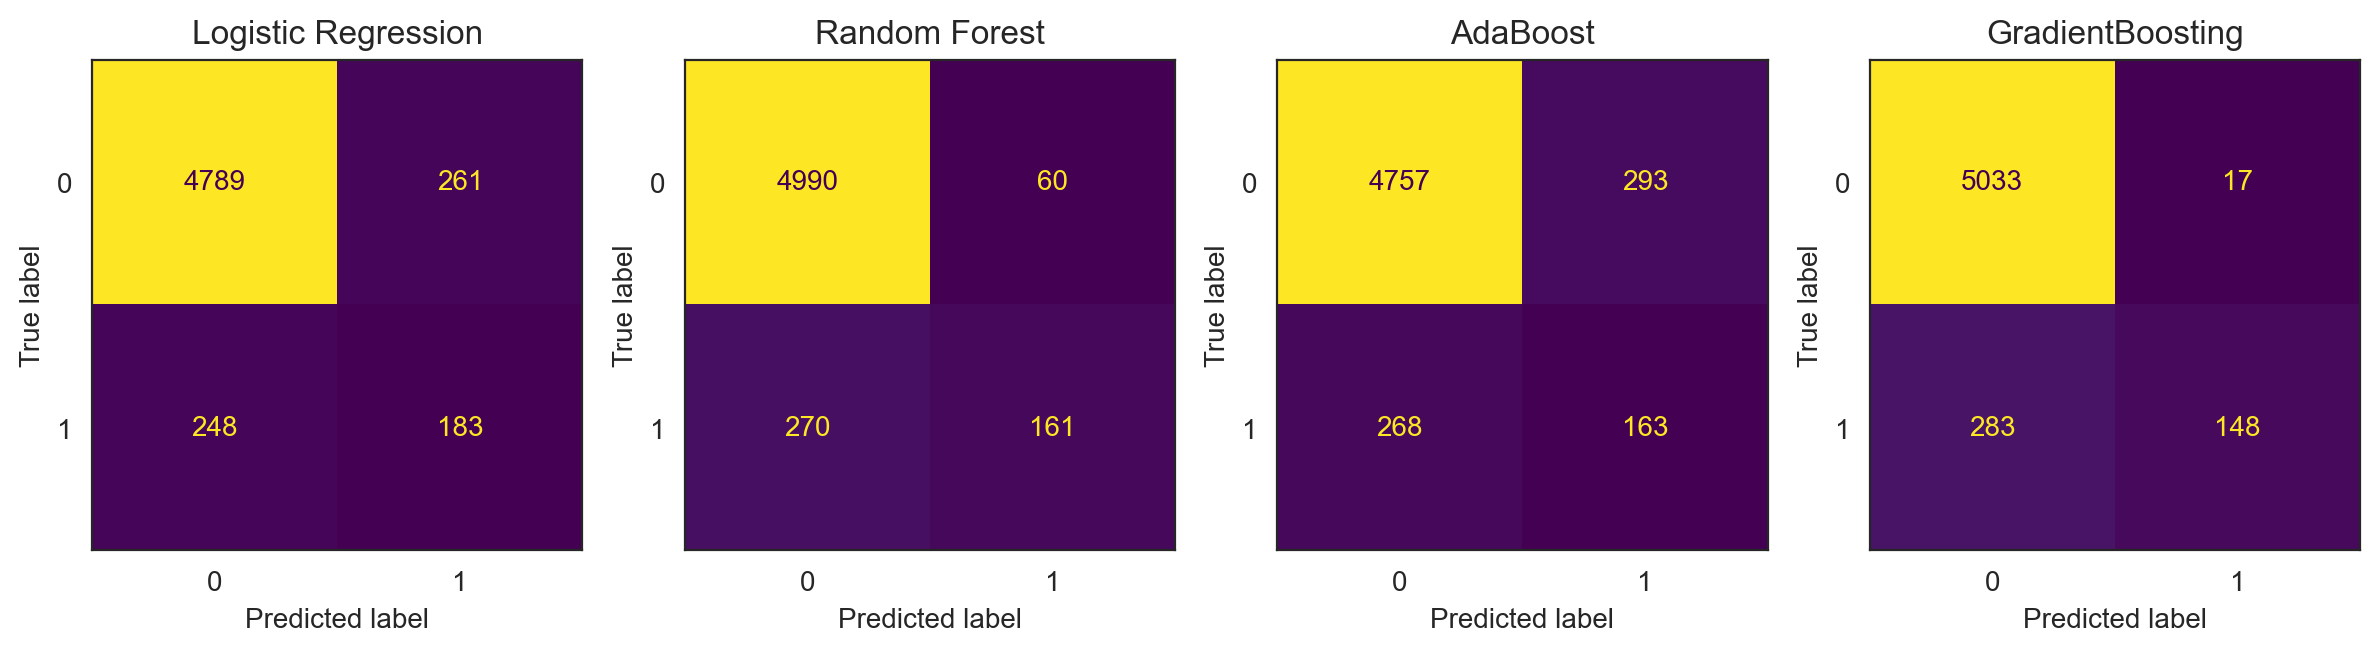

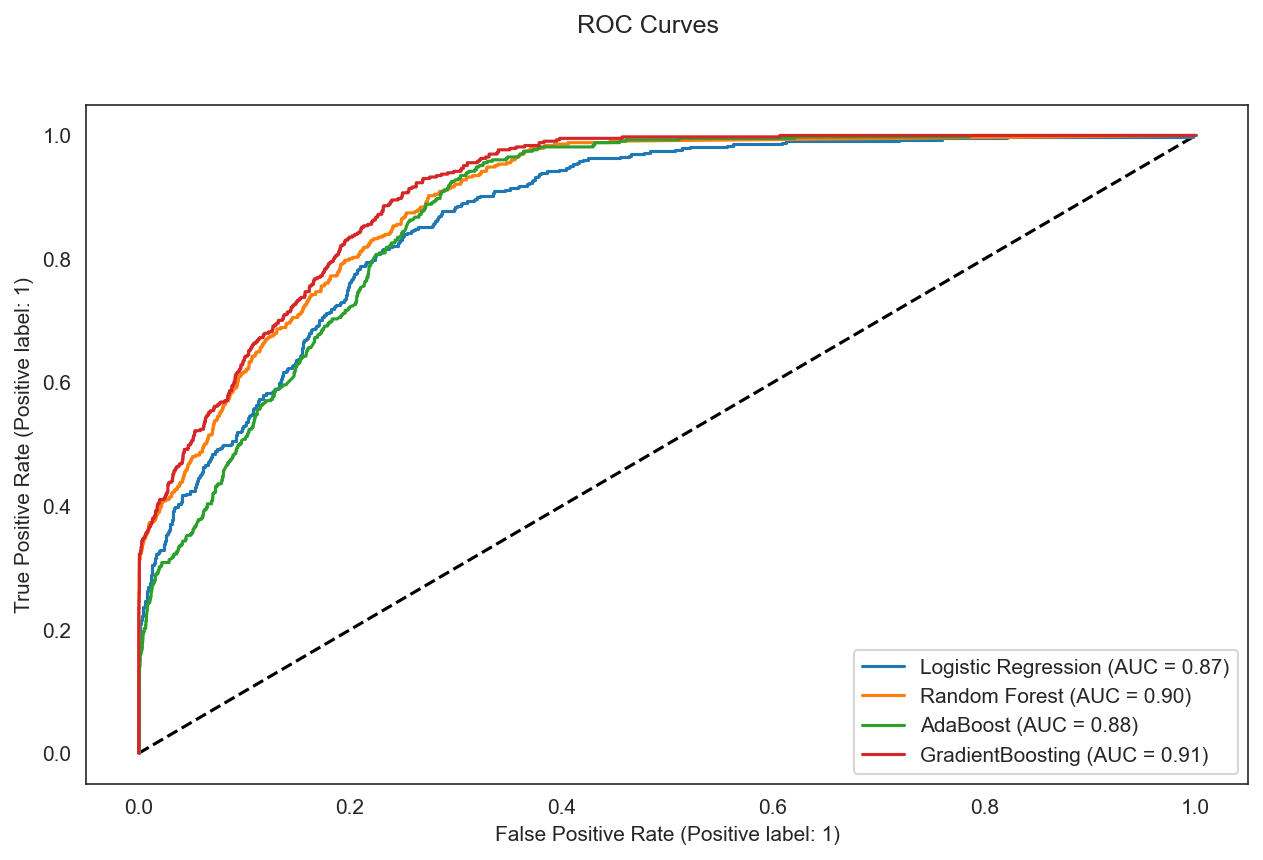

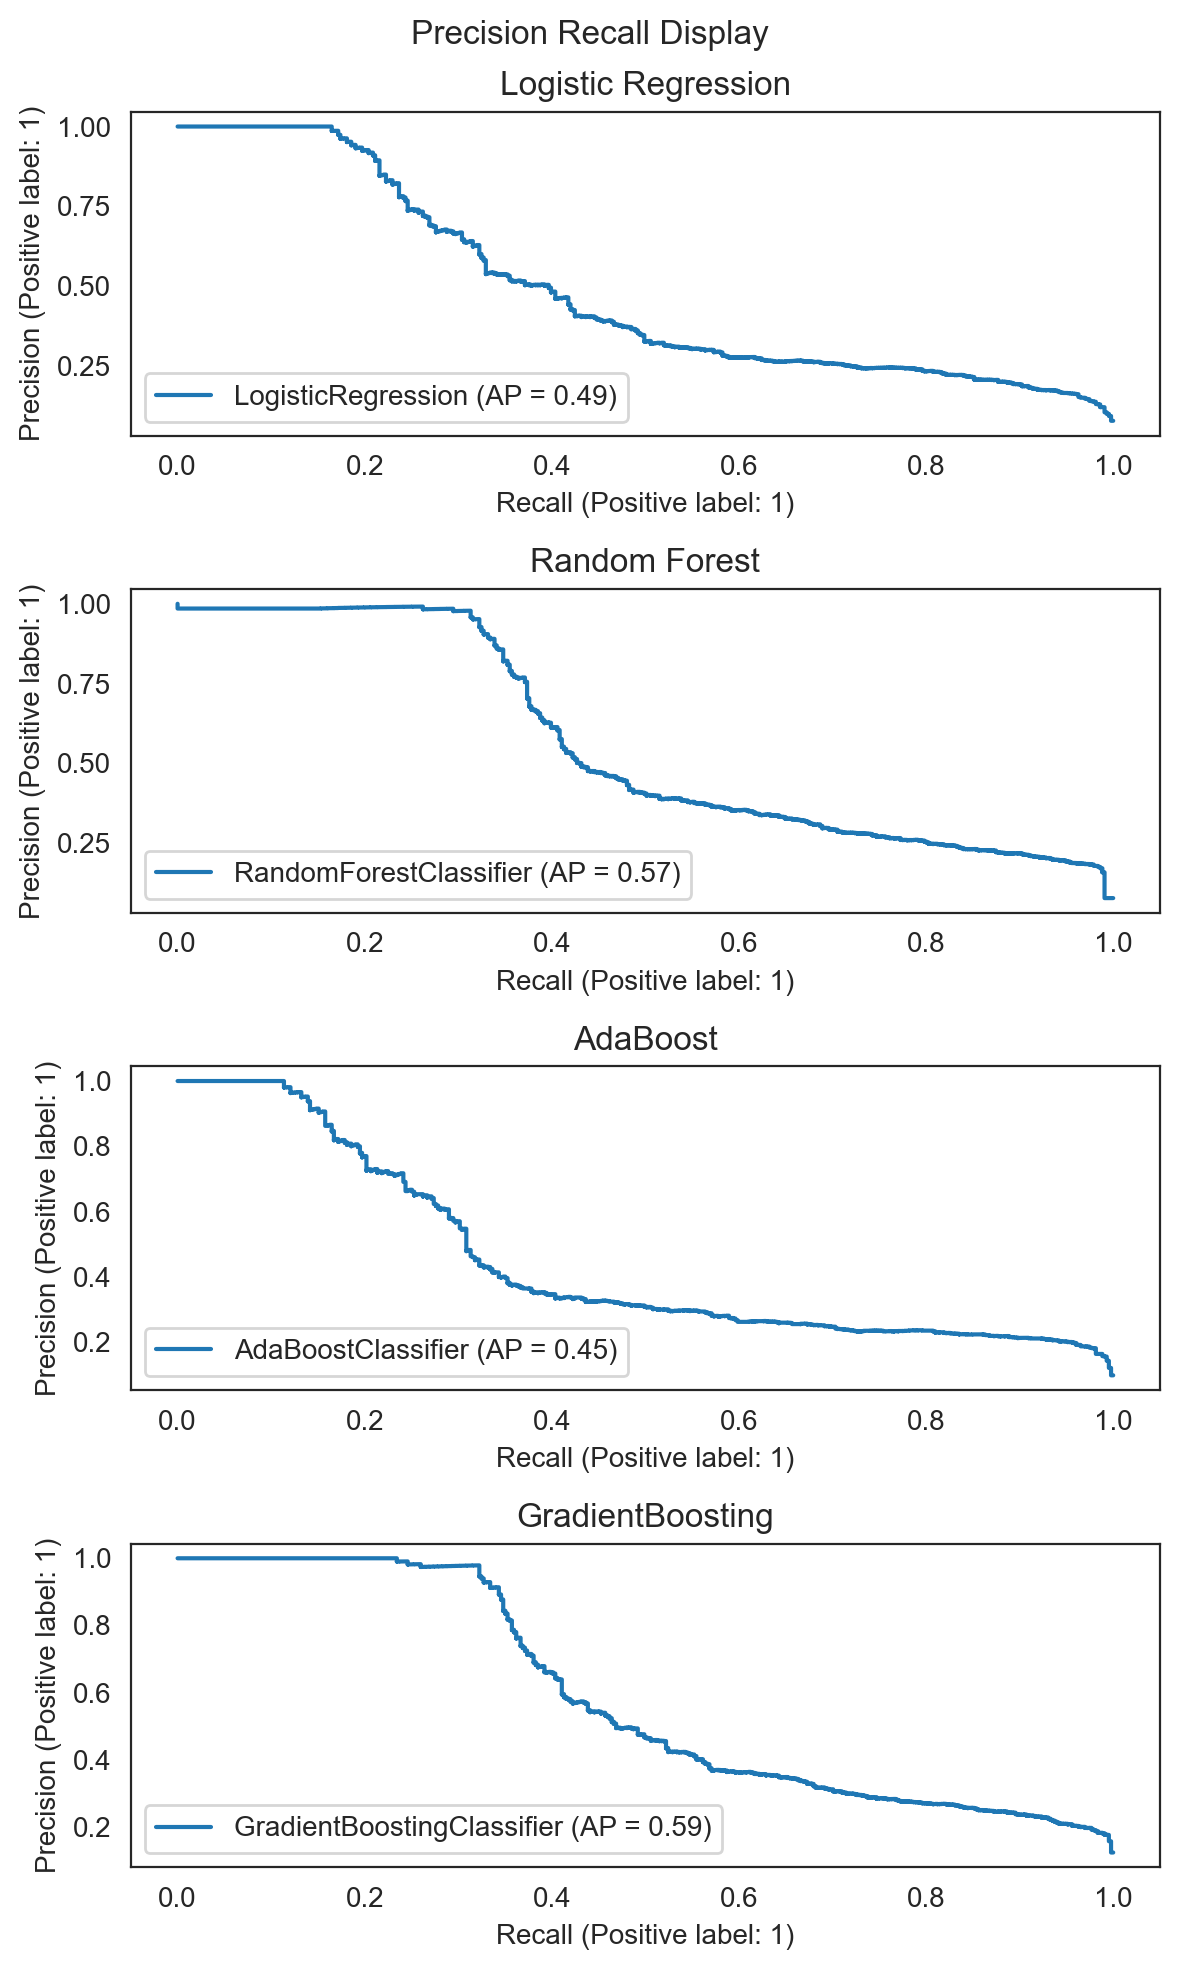

In [38]:
import importlib
importlib.reload(CustomFunctions)

sns.set_style('white')
CustomFunctions.plot_confusion_matrices(best_models, scaled_X_test, y_test)
CustomFunctions.classification_reports(best_models, scaled_X_test, y_test)
CustomFunctions.plot_roc_curves(best_models, scaled_X_test, y_test)
CustomFunctions.plot_precision_recall_disp(best_models, scaled_X_test, y_test)

Gradient Boosting performs better in most of the metrics shown here. Also, this model fits the business needs the most out of the models tested here. Recall that the company wanted to cut down on evaluation time.  This model has the best precision which means the prediction is trustworthy. 

Consider the following scenarios:
1. Gradient Boosting

    The model is recommending 165 employees to be promoted. Out of these employees, only 17 are wrongly classified as promoted (high precision). If the company wants to promote more, they have less work cutout for them. They can trust the prediction more, which means less time re-evaluating the machine predicted promotions and focus on manual evaluation for the rest of the candidates to meet their promotion quota. 
    
2. Logistic Regression

    This model has better true positives but also high false positives. In total, it recommends that the company promotes 444 employees. The company in this data, only promoted 431 employees. Compared to the Gradient Boosting model, Logistic regression has 35 more correct predictions but also many more incorrect predictions. Out of all the machine recommended candidates for this model, less than half was actually promoted. Meaning the company would have to be wary of the recommendation and have more work to do because they not only have to evaluate manually, they also have to sieve through the machine predicted promotees. 


<b>Conclusion</b>: 

Ideally, we would want our model to have both high recall and high precision but the target variable is imbalanced and our hands are tied by the precision-recall tradeoff. In this scenario, high precision is more favourable than high recall. Therefore, the Gradient Boosting model with the grid search parameters is the best model out of the four tested here. 

# Saving Model

In [40]:
final_model = GradientBoostingClassifier(**best_gb_params)

final_model.fit(X, y)

from joblib import dump

dump(final_model, 'models/gradient_boosting.joblib')

['models/gradient_boosting.joblib']